In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import data_processing
import math
import ipympl
from scipy import stats
from numpy import NaN
from matplotlib.pyplot import box


In [2]:
%matplotlib widget

In [3]:
# Load raw data
data = np.loadtxt("good_data_no_feedback/raw_data_20220803-160635")
data_crossed = np.loadtxt("good_data_no_feedback/timestamp_crossed_data_20220803-160635")
data_timestamps = np.loadtxt("good_data_no_feedback/timestamp_data_20220803-160635")
gui_data = np.load("good_data_no_feedback/combo_info_20220803-160632.npz")


In [4]:
NUM_SAMPLES_BUFFER = 600
FILTER_AFTER_N = 200
BP_LOW_CUTOFF = 20
BP_HIGH_CUTOFF = 500
ORDER = 2
LP_HIGH_CUTOFF = 5

Mvc = 393.49204563833797
percent_mvc = 0.3
mvc_threshold = percent_mvc*Mvc

In [5]:
data_crossed = data_crossed - data_timestamps[0]
data_timestamps = data_timestamps - data_timestamps[0]


# print(data_timestamps)
# print(data_crossed)

In [6]:
# Get gui combos 
repitions = gui_data['reps']
print("repitions:", gui_data['reps'])
print('Wt/Dt combos:', gui_data['combos'])

ID = np.log2(gui_data['combos'][:,1]/gui_data['combos'][:,0])
print("ID:",ID)

repitions: 10
Wt/Dt combos: [[ 140 1000]
 [  70 1500]
 [  70 1000]
 [  70 2000]
 [ 220 2000]
 [ 140 1500]
 [ 140 2000]
 [ 220 1500]
 [ 220 1000]]
ID: [2.83650127 4.42146377 3.83650127 4.83650127 3.18442457 3.42146377
 3.83650127 2.76938707 2.18442457]


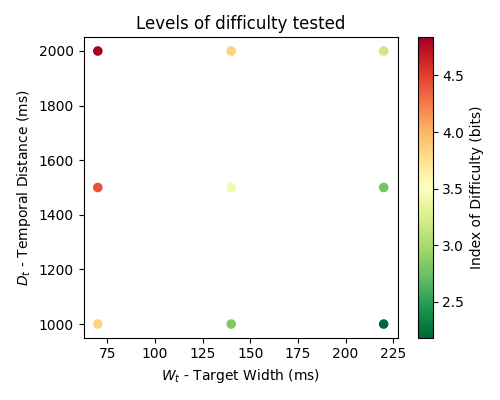

In [7]:
# Plot difficulty range
plt.figure(figsize=(5,4))
plt.scatter(gui_data['combos'][:,0], gui_data['combos'][:,1], c=ID, s=35)
plt.title('Levels of difficulty tested')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.ylabel('$D_{t}$ - Temporal Distance (ms)')
plt.set_cmap('RdYlGn_r')
cbar = plt.colorbar()
cbar.set_label('Index of Difficulty (bits)')
plt.tight_layout()
plt.show()

In [8]:
# fig,ax = plt.subplots(1, figsize=(5, 2))
# plt.scatter(ID, np.zeros(np.size(ID)), alpha=0.5)
# # Turn off tick labels
# ax.set_yticklabels([])
# ax.set_yticks([])
# plt.title("Index of Difficulty")
# plt.xlabel("Index of Difficulty")
# plt.show()


In [9]:
# print(data_timestamps)
# print(data_crossed)

In [10]:
data_new = data[~(data == 0).all(axis=1)]
timestamp_data_new = data_timestamps[~(data == 0).all(axis=1)]
data_crossed_new = data_crossed[~(data_crossed == 0)]
x_data = (data_new[:, 6] - data_new[0, 6])/4000

In [11]:


process = data_processing.postProcessData(4000, data_new[:,0])
process.processAll(BP_LOW_CUTOFF, BP_HIGH_CUTOFF, LP_HIGH_CUTOFF, ORDER, FILTER_AFTER_N)


In [12]:

def findThresholdCrossing(lpData, threshold):
    threshold_crossings = np.diff(lpData > threshold, prepend=False)
    positive_difference = np.diff(lpData, prepend=0) >= 0 
    threshold_crossings_positive = np.argwhere(np.logical_and(threshold_crossings, positive_difference))[:,0]
    return threshold_crossings_positive

threshold_crossings_up = findThresholdCrossing(process.lpFilteredData, mvc_threshold)

def thresholdCrossed(lpData, threshold):
    threshold_crossings = np.diff(lpData > threshold)
    print("function crossing", threshold_crossings)
    positive_difference = np.diff(lpData) > 0    
    print("funciton difference", positive_difference) 
    thresholdCrossed =  np.any(np.logical_and(threshold_crossings, positive_difference))
    return thresholdCrossed

In [13]:
stop_cue = (np.where(np.diff(data_new[:, 4]) == 1)[0])
start_cue = (np.where(np.diff(data_new[:, 4]) == -1)[0])

if stop_cue[0] < start_cue[0]:
    stop_cue = stop_cue[1:]

print("threshold corssing:", threshold_crossings_up)
print("start:", start_cue)
print("stop:", stop_cue)

threshold corssing: [ 17980  22273  26000  30023  33972  37702  41572  45549  49834  54318
  60937  66959  72753  79002  84929  90845  96772 102935 108588 114801
 122083 125631 129924 133923 137949 141894 146199 149475 153482 157672
 172203 180088 187792 195750 204013 211680 220176 227790 235691 244182
 260102 268310 276219 284025 291777 299878 307575 315619 323311 332014
 343162 348792 354758 360918 367342 372976 379207 385051 390893 397185
 411971 420003 427628 435906 443716 451826 459988 468065 475604 483743
 492827 498924 505076 510689 516969 522951 529032 534791 540842 547039
 554129 557983 561762 565790 569726 573637 577886 581707 585659 589553
 594221 598263]
start: [  9497  17994  21995  25989  29970  34037  38032  42023  46027  50008
  53993  61021  67020  72985  78991  84982  91013  97001 103003 108977
 115022 122008 126007 130024 134007 137994 141998 146004 149977 153961
 157965 172012 180005 187958 196018 203956 212013 220020 228000 235961
 243989 259990 267974 275961 28394

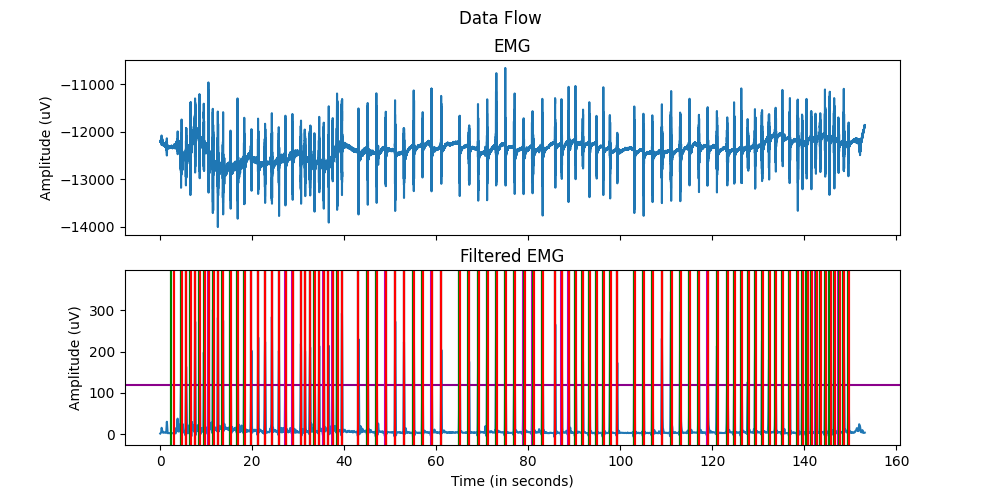

In [14]:
# plt.figure()
fig, axs = plt.subplots(2, figsize=(10, 5), sharex=True) # dont need status or lsl clock
fig.suptitle('Data Flow')

axs[0].plot(x_data, data_new[:, 0])
axs[0].title.set_text('EMG')

for xc in start_cue:
    axs[1].axvline(x=xc/4000, color='g')
for xc in stop_cue:
    axs[1].axvline(x=xc/4000, color='r')

axs[1].plot(x_data, process.lpFilteredData)
axs[1].title.set_text('Filtered EMG')
axs[1].axhline(y=mvc_threshold, color='darkmagenta')

for ups in threshold_crossings_up:
    axs[1].axvline(x=ups/4000, color='m')

for xc in start_cue:
    axs[1].axvline(x=xc/4000, color='g')
for xc in stop_cue:
    axs[1].axvline(x=xc/4000, color='r')

    
axs[1].set_xlabel('Time (in seconds)')
axs[1].set_ylabel('Amplitude (uV)')
axs[0].set_ylabel('Amplitude (uV)')
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.show()



In [15]:

stop_cue_timestamp = data_timestamps[np.where(np.diff(data_new[:, 4]) == 1)[0]]
print(stop_cue_timestamp)
start_cue_timestamp = data_timestamps[np.where(np.diff(data_new[:, 4]) == -1)[0]]
print(start_cue_timestamp)


[  2.9190022   4.6369003   5.6618012   6.6560583   7.6524868   8.6456604
   9.6523523  10.6447493  11.6402322  12.6519231  13.6696829  15.3167109
  16.8184875  18.3290266  19.8391199  21.3208571  22.8232892  24.3408713
  25.8414351  27.3244572  28.8181833  30.5776707  31.5974593  32.569121
  33.5830231  34.5913448  35.589711   36.5886319  37.5842389  38.5747367
  39.5790878  43.0764171  45.0772705  47.0753546  49.0738858  51.0818182
  53.0733037  55.0704673  57.0779832  59.0851481  61.0768994  65.208795
  67.2414304  69.2281146  71.2233437  73.2272298  75.234982   77.2263471
  79.2261553  81.2412288  83.2133898  85.8850071  87.4026684  88.8999009
  90.4056115  91.8923398  93.4052122  94.8901188  96.4136099  97.9067666
  99.3999055 103.1469792 105.1481506 107.1532938 109.1468709 111.155718
 113.1538847 115.1474375 117.1481172 119.1426092 121.166049  123.4758824
 124.9738891 126.4862576 127.9957095 129.4933104 130.972136  132.473736
 133.9711638 135.475611  136.9619056 138.716763  139.73

In [16]:
data_crossed_small = data_crossed_new[data_crossed_new<np.max(timestamp_data_new)]
data_crossed_small = data_crossed_small[data_crossed_small>0]
print(data_crossed_small)

[  4.5040248   4.5025248   4.5946503   5.5627056   5.5599556   6.5061023
   7.5106656   8.512124    8.495874    9.4272017   9.4272017  10.4371739
  10.4025221  11.409781   11.401781   12.4791206  13.6039329  13.6004329
  15.2501633  15.2456633  16.7754875  16.7484875  18.2155127  18.2062627
  19.7706199  21.2438159  21.2400659  22.7344791  22.7349791  24.1893459
  25.7473164  25.7463164  27.1803405  27.1640905  28.7411739  28.7109239
  30.5419594  30.5337094  31.4201498  32.493871   32.4779353  33.4942731
  33.4885231  34.5163448  34.5048448  35.493211   35.489461   36.5651319
  37.3721128  37.3683628  38.3764274  38.3719274  39.4285467  39.4287967
  43.0686671  45.0450205  45.0447705  46.9884561  46.9652061  48.9559845
  48.9492345  51.0295998  52.9296628  52.9279128  55.0732173  55.0524673
  56.9581514  56.9932332  58.9282229  58.9264729  61.0711494  61.0501494
  61.1321466  65.0550084  65.0527584  67.1003715  67.1006215  69.0980194
  69.0770194  71.0189411  72.9565546  74.9923371  7

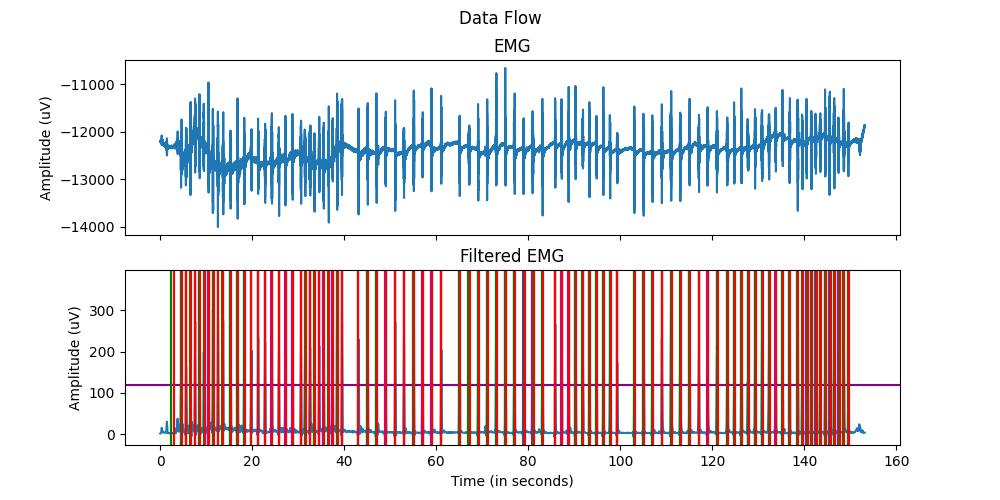

In [17]:
fig, axs = plt.subplots(2, figsize=(10, 5), sharex=True) # dont need status or lsl clock
fig.suptitle('Data Flow')

axs[0].plot(timestamp_data_new, data_new[:, 0])
axs[0].title.set_text('EMG')

for xc in start_cue_timestamp:
    axs[1].axvline(x=xc, color='g')
for xc in stop_cue_timestamp:
    axs[1].axvline(x=xc, color='r')

axs[1].plot(timestamp_data_new, process.lpFilteredData)
axs[1].title.set_text('Filtered EMG')
axs[1].axhline(y=mvc_threshold, color='darkmagenta')

for ups in data_crossed_small:
    axs[1].axvline(x=ups, color='m')

for xc in start_cue_timestamp:
    axs[1].axvline(x=xc, color='g')
for xc in stop_cue_timestamp:
    axs[1].axvline(x=xc, color='r')

    
axs[1].set_xlabel('Time (in seconds)')
axs[1].set_ylabel('Amplitude (uV)')
axs[0].set_ylabel('Amplitude (uV)')
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.show()

In [18]:
print("start:", start_cue_timestamp)
print("stop:",stop_cue_timestamp)
print("corssed:",data_crossed_small)

start: [  2.3858831   4.5032748   5.5027648   6.5023523   7.4944156   8.509624
   9.5057017  10.5181739  11.5087294  12.5198706  13.5082841  15.2577109
  16.7609875  18.2620127  19.7621199  21.2503159  22.7652892  24.2600742
  25.7644351  27.2583079  28.7636739  30.5179594  31.5209593  32.511871
  33.5072731  34.5125948  35.512711   36.4879223  37.5077389  38.499378
  39.4990467  43.0189171  45.0158884  47.0049561  49.0137345  51.0128498
  53.0152191  55.0119673  57.0207332  59.0091481  60.9993994  65.0064105
  67.0155047  69.0071087  70.9964411  73.0230765  75.0093371  77.0183945
  79.0082637  81.0154962  83.012802   85.7630342  87.2542505  88.7741455
  90.2666124  91.7453816  93.2450601  94.7624201  96.2558726  97.7676203
  99.2577246 103.0210148 105.0053431 107.0154176 108.9882699 111.0105991
 113.0204133 115.0128976 117.0211382 119.0147929 120.9983439 123.2457653
 124.7654789 126.2538671 127.7515073 129.2637508 130.7591038 132.2781045
 133.7678951 135.2692156 136.7532146 138.501550

In [19]:
# Exclude the first pulse - that is ardunio power cycling
start_cue_timestamp = start_cue_timestamp[1:] # [1:]
stop_cue_timestamp = stop_cue_timestamp[1:] #[1:]

threshold_closest_timestamp = np.empty(np.size(start_cue_timestamp[:]))
threshold_closest_timestamp[:] = np.nan
correct_timestamp = np.empty(np.size(start_cue_timestamp[:]))
###for every value in the strt_cue 
for idx_cue, cue in enumerate(start_cue_timestamp[:]):

    after_start_timestamp = start_cue_timestamp[idx_cue] <= data_crossed_small
    before_stop_timestamp = data_crossed_small <= stop_cue_timestamp[idx_cue]
    # check if there is a value between start_cue and stop cue
    if np.any(np.logical_and(after_start_timestamp, before_stop_timestamp)):
        in_target = np.argwhere(np.logical_and(after_start_timestamp, before_stop_timestamp))
        closet_value = in_target[0]
        threshold_closest_timestamp[idx_cue] = data_crossed_small[in_target[0]]
        correct_timestamp[idx_cue] = True
    else:
        # if not - get closet 
        idx = (np.abs(data_crossed_small - start_cue_timestamp[idx_cue])).argmin()

        threshold_closest_timestamp[idx_cue] = data_crossed_small[idx]
        correct_timestamp[idx_cue] = False
         # get rid of values greater than half the distance between the next cue 

print("closest:", threshold_closest_timestamp)
print("correctness:", correct_timestamp)

threshold_distance_timestamp = threshold_closest_timestamp - start_cue_timestamp
print("distance away:", threshold_distance_timestamp)


threshold_distance_timestamp[threshold_distance_timestamp > 1] = NaN
threshold_distance_timestamp[threshold_distance_timestamp < -1] = NaN
print("distance away:", threshold_distance_timestamp)

closest: [  4.5040248   5.5627056   6.5061023   7.5106656   8.512124    9.4272017
  10.4371739  11.409781   12.4791206  13.6039329  15.2501633  16.7754875
  18.2155127  19.7706199  21.2438159  22.7349791  24.1893459  25.7473164
  27.1803405  28.7411739  30.5419594  31.4201498  32.493871   33.4942731
  34.5163448  35.493211   36.5651319  37.3721128  38.3764274  39.4287967
  43.0686671  45.0450205  46.9884561  48.9559845  51.0295998  52.9296628
  55.0524673  56.9932332  58.9282229  61.0711494  65.0550084  67.1003715
  69.0980194  71.0189411  72.9565546  75.0716534  76.9281065  78.9167637
  80.8510542  83.022302   85.8205342  87.2397505  88.7401455  90.2541124
  91.8513398  93.2757589  94.8184201  96.2838726  97.7458703  99.3159746
 103.0187648 105.0553431 106.9304948 108.9900199 110.9574509 112.9801183
 115.0203976 117.0456933 118.9220429 120.9650939 123.2342653 124.7537289
 126.2836171 127.7882573 129.2807761 130.7628538 132.2948545 133.7330235
 135.2364656 136.7744646 138.5490951 139.5

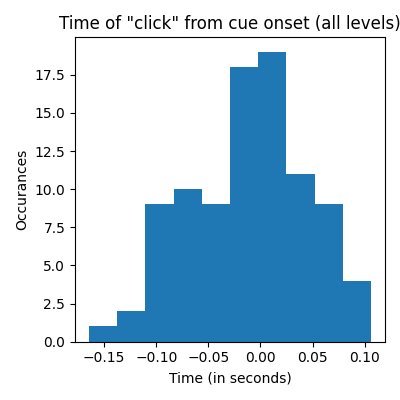

In [41]:
plt.figure(figsize=(4,4))
plt.hist(threshold_distance_timestamp, bins=10)
plt.title('Time of "click" from cue onset (all levels)')
plt.xlabel('Time (in seconds)')
plt.ylabel('Occurances')
plt.tight_layout()
plt.show()

In [21]:
rt_normalized = (threshold_distance_timestamp - np.mean(threshold_distance_timestamp))/np.std(threshold_distance_timestamp)
stats.kstest(rt_normalized, stats.norm.cdf)
# if p val is greater than 0.05 -> GAUSSIAN

KstestResult(statistic=0.05917168513297494, pvalue=0.8850212793000048)

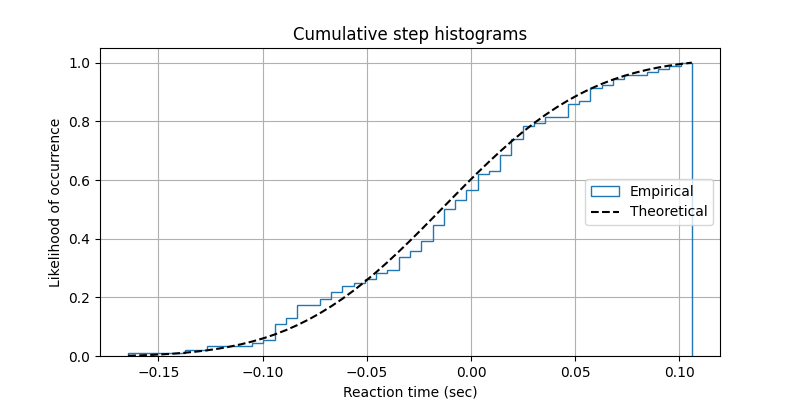

In [22]:

np.random.seed(0)

mu = np.mean(threshold_distance_timestamp)
sigma = np.std(threshold_distance_timestamp)
n_bins = 50

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(threshold_distance_timestamp, n_bins, density=1, histtype='step',
                           cumulative=True, label='Empirical')

# Add a line showing the expected distribution.
y = stats.norm.pdf(bins, mu, sigma).cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')



# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Reaction time (sec)')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

In [23]:
repitions = gui_data['reps'] 
print("repitions:", repitions)
correct_timestamp = correct_timestamp[:-1]
level = np.arange(len(correct_timestamp))//repitions
print('Levels:', level)




performance = np.bincount(level,correct_timestamp)/np.bincount(level)
print('performance per level:', performance)

repitions: 10
Levels: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9]
performance per level: [0.6 0.2 0.3 0.5 0.6 0.6 0.4 0.6 0.3 1. ]


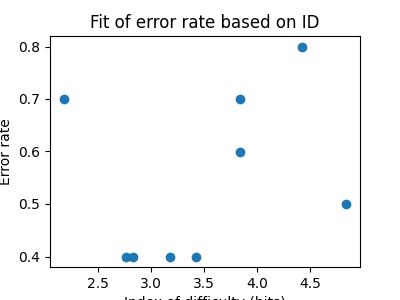

In [24]:
plt.figure(figsize=(4,3))
plt.scatter(ID, 1-performance[0:np.shape(ID)[0]])
plt.title('Fit of error rate based on ID')
plt.xlabel('Index of difficulty (bits)')
plt.ylabel('Error rate')
plt.show()
# plt.xlim([0, 4])
plt.ylim([0, 1.05])
plt.tight_layout()

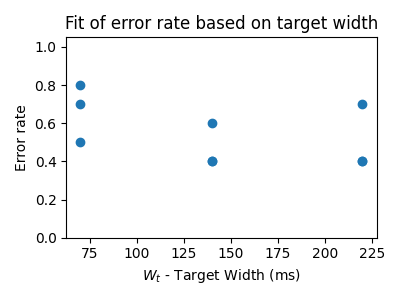

In [25]:
plt.figure(figsize=(4,3))
plt.scatter(gui_data['combos'][:,0], 1-performance[0:np.shape(ID)[0]])
plt.title('Fit of error rate based on target width')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.ylabel('Error rate')
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()


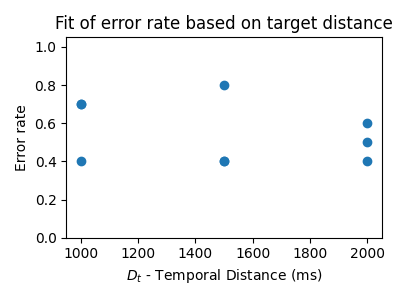

In [26]:
plt.figure(figsize=(4,3))
plt.scatter(gui_data['combos'][:,1], 1-performance[0:np.shape(ID)[0]])
plt.title('Fit of error rate based on target distance')
plt.xlabel('$D_{t}$ - Temporal Distance (ms)')
plt.ylabel('Error rate')
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

[array([-0.0075476,  0.0145   , -0.0465   ,  0.0085   , -0.0065   ,
       -0.0303101, -0.0707283, -0.0171187, -0.0779674, -0.0225   ,
        0.024    , -0.1008095, -0.018    , -0.013    ,  0.00375  ,
       -0.0195   ,  0.0772096, -0.1356261, -0.1229506, -0.07025  ,
        0.04975  ,  0.0291321, -0.0165   , -0.05775  ,  0.01675  ,
       -0.0855563,  0.0405   , -0.0275   , -0.0809252,  0.07175  ]), array([ 0.00075  ,  0.0599408,  0.00375  ,  0.01625  ,  0.0025   ,
       -0.0785   , -0.081    , -0.0989484, -0.04075  ,  0.0956488,
        0.0575   , -0.0145   , -0.034    , -0.0125   ,  0.1059582,
        0.0306988,  0.056    ,  0.028    , -0.02175  ,  0.05825  ,
       -0.00225  ,  0.05     , -0.0849228,  0.00175  , -0.0531482,
       -0.040295 ,  0.0075   ,  0.0245551, -0.09275  , -0.03325  ]), array([ 0.0485979,  0.0848668,  0.0909107,  0.0225   , -0.0665219,
        0.0623163, -0.090288 , -0.0915   , -0.164442 ,  0.0095   ,
       -0.0115   , -0.01175  ,  0.02975  ,  0.03675  ,  0

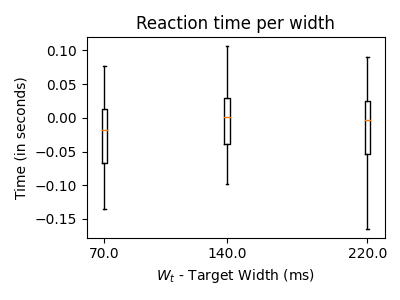

In [27]:
widths = gui_data['combos'][:,0]//70
# print(widths)
width_levels = np.repeat(widths, repitions)
# print(width_levels)

box_plot_data_width = np.split(threshold_distance_timestamp, np.unique(width_levels, return_index=True)[1][1:])
# print(box_plot_data_width)

width_split = [threshold_distance_timestamp[:-2][width_levels == i] for i in range(width_levels.max() + 1)]
width_split = width_split[1:]
print(width_split)
print(np.shape(width_split))

fig1, ax1 = plt.subplots(figsize=(4,3))
ax1.set_title('')
ax1.boxplot(width_split, positions=np.unique(gui_data['combos'][:,0]), widths=3)
plt.title('Reaction time per width')
plt.ylabel('Time (in seconds)')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.xlim([60, 230])
plt.tight_layout()
from matplotlib.ticker import FormatStrFormatter
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

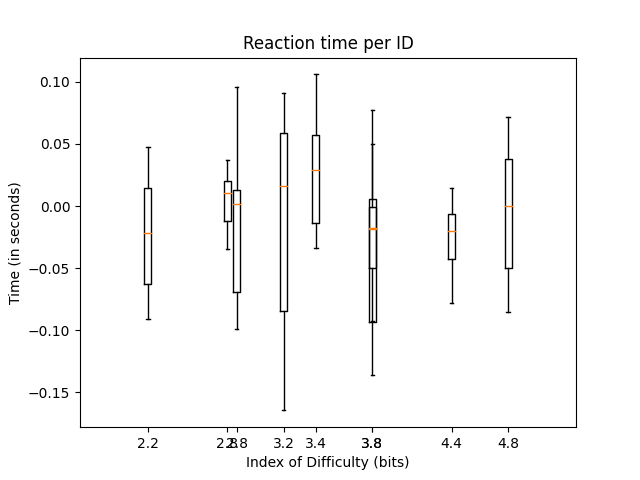

In [28]:
box_plot_data = np.split(threshold_distance_timestamp, np.unique(level, return_index=True)[1][1:])
# print(box_plot_data)

fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(box_plot_data[0:np.shape(ID)[0]], positions=ID.round(3), widths=0.05)
plt.title('Reaction time per ID')
plt.ylabel('Time (in seconds)')
plt.xlabel('Index of Difficulty (bits)')
from matplotlib.ticker import FormatStrFormatter
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [29]:
# # Exclude the first pulse - that is ardunio power cycling
# start_cue = start_cue[1:] # [1:]
# stop_cue = stop_cue[1:] #[1:]

# threshold_closest = np.empty(np.size(start_cue[:]))
# threshold_closest[:] = np.nan
# correct = np.empty(np.size(start_cue[:]))
# ###for every value in the strt_cue 
# for idx_cue, cue in enumerate(start_cue[:]):

#     after_start = start_cue[idx_cue] <= threshold_crossings_up
#     before_stop = threshold_crossings_up <= stop_cue[idx_cue]
#     # check if there is a value between start_cue and stop cue
#     if np.any(np.logical_and(after_start, before_stop)):
#         in_target = np.argwhere(np.logical_and(after_start, before_stop))
#         closet_value = in_target[0]
#         threshold_closest[idx_cue] = threshold_crossings_up[in_target[0]]
#         correct[idx_cue] = True
#     else:
#         # if not - get closet 
#         idx = (np.abs(threshold_crossings_up - start_cue[idx_cue])).argmin()

#         threshold_closest[idx_cue] = threshold_crossings_up[idx]
#         correct[idx_cue] = False
#          # get rid of values greater than half the distance between the next cue 

# print("closest:", threshold_closest)
# print("correctness:", correct)

# threshold_distance = threshold_closest - start_cue
# print("distance away:", threshold_distance)


# threshold_distance[threshold_distance > 4000] = NaN
# threshold_distance[threshold_distance < -4000] = NaN
# print("distance away:", threshold_distance)

In [30]:
# plt.figure()
# plt.hist(threshold_distance/4000, bins=15)
# plt.title('Time of "click" from cue onset (all levels)')
# plt.xlabel('Time (in seconds)')
# plt.ylabel('Occurances')
# plt.show()

In [31]:
# rt = threshold_distance/4000
# print(rt)
# rt = rt[~np.isnan(rt)]
# print(rt)

In [32]:
# rt_normalized = (rt - np.mean(rt))/np.std(rt)
# stats.kstest(rt_normalized, stats.norm.cdf)
# # if p val is greater than 0.05 -> GAUSSIAN

In [33]:


# np.random.seed(0)

# mu = np.mean(rt)
# sigma = np.std(rt)
# n_bins = 50

# fig, ax = plt.subplots(figsize=(8, 4))

# # plot the cumulative histogram
# n, bins, patches = ax.hist(rt, n_bins, density=1, histtype='step',
#                            cumulative=True, label='Empirical')

# # Add a line showing the expected distribution.
# y = stats.norm.pdf(bins, mu, sigma).cumsum()
# y /= y[-1]

# ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')



# # tidy up the figure
# ax.grid(True)
# ax.legend(loc='right')
# ax.set_title('Cumulative step histograms')
# ax.set_xlabel('Reaction time (sec)')
# ax.set_ylabel('Likelihood of occurrence')

# plt.show()

In [34]:
# repitions = gui_data['reps'] 
# print("repitions:", repitions)
# level = np.arange(len(correct))//repitions
# print('Levels:', level)
# performance = np.bincount(level,correct)/np.bincount(level)
# print('performance per level:', performance)


In [35]:


# box_plot_data = np.split(threshold_distance/4000, np.unique(level, return_index=True)[1][1:])
# print(box_plot_data)

In [36]:
# for idx, data in enumerate(box_plot_data):
#     box_plot_data[idx] = data[~np.isnan(data)]



In [37]:
# fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
# ax1.boxplot(box_plot_data[0:np.shape(ID)[0]], positions=ID.round(3), widths=0.05)
# plt.title('Reaction time per ID')
# plt.ylabel('Time (in seconds)')
# plt.xlabel('Index of Difficulty (bits)')
# from matplotlib.ticker import FormatStrFormatter
# ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [38]:
# plt.figure(figsize=(5,3))
# plt.scatter(ID, 1-performance[0:np.shape(ID)[0]])
# plt.title('Fit of error rate based on ID')
# plt.xlabel('Index of difficulty (bits)')
# plt.ylabel('Error rate')
# plt.show()
# # plt.xlim([0, 4])
# plt.ylim([0, 1.05])
# plt.tight_layout()

In [39]:
# plt.figure(figsize=(5,3))
# plt.scatter(gui_data['combos'][:,0], 1-performance[0:np.shape(ID)[0]])
# plt.title('Fit of error rate based on target width')
# plt.xlabel('$W_{t}$ - Target Width (ms)')
# plt.ylabel('Error rate')
# plt.ylim([0, 1.05])
# plt.tight_layout()
# plt.show()


In [40]:
# plt.figure(figsize=(5,3))
# plt.scatter(gui_data['combos'][:,1], 1-performance[0:np.shape(ID)[0]])
# plt.title('Fit of error rate based on target distance')
# plt.xlabel('$D_{t}$ - Temporal Distance (ms)')
# plt.ylabel('Error rate')
# plt.ylim([0, 1.05])
# plt.tight_layout()
# plt.show()